# Week 7 - GAN Part 3 and Evaluation Metrics Notebook

In this notebook, we will solve questions on GANs and evaluation metrics of generative models in general.

 - This notebook is prepared using PyTorch. However, you can use any Python package you want to implement the necessary functions in questions.
 - If the question asks you to implement a specific function, please do not use its readily available version from a package and implement it yourself.

## Question 1

Please answer the questions below:

1. Please explain the concept of batch normalization. What problem does it solve and how?
2. What is spectral normalization and why do we use it?
3. What is the meaning of class-conditional GAN? How do we make GANs class conditional?
4. What are the main differences between StyleGAN-v1 and StyleGAN-v2?
5. Why is it so hard to quantitatively evaluate generative models?
6. What assumptions are we making on the data/model distribution when using Inception Score and Frechet Inception distance?

You can write your answer for each question in the markdown cell below:

**Please write your answer for each question here**

## Question 2

**Part 1**: Implement regular batch normalization for convolutional layers. Definition of the function and the input to test is given.

For reference, you can use the batch normalization paper given [here](https://arxiv.org/abs/1502.03167). Also, you can refer to the lecture slides.

Please note that we will implement a simple version of batch normalization, and in this simple version we will not be using *running mean*, *running variance*, and *momentum* parameters.

In [ ]:
import torch
torch.manual_seed(0)

batch_size = 16
num_channels = 12

input_tensor = torch.normal(3, 10, size=(batch_size, num_channels, 24, 24))

In [ ]:
def batch_normalization_conv(X, gamma, beta, eps=1e-8):
  """Performs batch normalization operation for convolutional layer output
    Args:
        X: input tensor (N x C x H x W)
        gamma: scale variable
        beta: offset variable
        eps: epsilon value
    Returns:
        the resulting tensor of the batch norm operation
  """
  #######################
  # Write code here
  #######################
  mean = X.mean(dim=(0, 2, 3), keepdim=True)
  var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)

  X_hat = (X - mean) / torch.sqrt(var + eps)
  return gamma * X_hat + beta

In [ ]:
print("Expected Output:")
print(batch_normalization_conv(input_tensor, gamma=1, beta=0)[0,0,0,:])

Expected Output:
tensor([-1.1380, -1.1645, -0.2613, -0.4449,  0.8398,  0.6829, -0.3268, -2.1290,
         0.3125, -1.2757,  0.3403,  0.2984,  0.1098,  1.2294,  1.1083, -0.2580,
        -1.3651, -1.7090,  0.5573,  0.7845,  0.5895, -1.5679, -0.3522,  1.8458])


In [ ]:
input_tensor[0,0,0,:]

tensor([ -8.2584,  -8.5236,   0.4942,  -1.3388,  11.4871,   9.9201,  -0.1601,
        -18.1522,   6.2227,  -9.6333,   6.4998,   6.0813,   4.1984,  15.3766,
         14.1678,   0.5272, -10.5265, -13.9593,   8.6665,  10.9351,   8.9884,
        -12.5510,  -0.4136,  21.5301])

**Part 2**: Implement class-conditional batch normalization for convolutional layers. You can copy-paste and modify your code from part 1 and use the same input above with the given **Y** vector below. You can refer to the lecture slides for the pseudocode.

This part is a bit tricky since we cannot directly use the class labels as inputs to a feed-forward neural network.

We therefore use the embeddings of the classes instead. We define 10-dimensional embeddings to represent our $y \in {0, 1}$ classes as float vectors.

We then randomly generate 0 and 1 values with the amount of **batch_size** and get their embeddings.

In our function, we will imitate a feed-forward neural network to implement class-conditional batch normalization, so we also define the weights and biases of this very simple perceptron as *gamma_w*, *gamma_b*, *beta_w*, and *beta_b*.

In [ ]:
import torch.nn as nn

# Assuming binary classification (binary labels)
num_classes = 2
embedding_dim = 10

# 10-dimensional embeddings for two classes: 2 x 10
class_embeddings = nn.Embedding(num_classes, embedding_dim)

# 16 random labels of 0 and 1
input_labels = torch.randint(0, 2, size=(batch_size,))

# Get class embeddings
input_label_embeddings = class_embeddings(input_labels)

gamma_w = torch.randn(embedding_dim, num_channels)
gamma_b = torch.zeros(1, num_channels)
beta_w = torch.randn(embedding_dim, num_channels)
beta_b = torch.zeros(1, num_channels)

In [ ]:
def cond_batch_normalization_conv(X, Y, gamma_w, gamma_b, beta_w, beta_b, eps=1e-8):
  """Performs conditional batch normalization operation for convolutional layer output
    Args:
        X: input tensor (N x C x H x W)
        Y: input labels (N x emb_dim)
        gamma_w: scale weights (emb_dim x C)
        gamma_b: scale bias (1 x C)
        beta_w: offset weights (emb_dim x C)
        beta_b: offset bias (1 x C)
        eps: epsilon value
    Returns:
        the resulting tensor of the batch norm operation
  """
  #######################
  # Write code here
  #######################
  mean = X.mean(dim=(0, 2, 3), keepdim=True)
  var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)

  X_hat = (X - mean) / torch.sqrt(var + eps)
  
  gamma = torch.matmul(Y, gamma_w) + gamma_b
  beta = torch.matmul(Y, beta_w) + beta_b

  gamma = gamma.unsqueeze(2).unsqueeze(2)
  beta = beta.unsqueeze(2).unsqueeze(2)

  return gamma * X_hat + beta

In [ ]:
print("Expected Output:")
print(cond_batch_normalization_conv(input_tensor, input_label_embeddings, gamma_w, gamma_b, beta_w, beta_b)[0, 0, 0, :].data)

Expected Output:
tensor([-4.8654, -4.9883, -0.8110, -1.6601,  4.2812,  3.5554, -1.1141, -9.4485,
         1.8426, -5.5023,  1.9710,  1.7771,  0.9049,  6.0829,  5.5230, -0.7957,
        -5.9161, -7.5062,  2.9747,  4.0255,  3.1238, -6.8539, -1.2315,  8.9334])


## Question 3

Implement the adaptive instance normalization (AdaIN) from StyleGAN. You can refer to the lecture slides or the StyleGAN paper [here](https://arxiv.org/abs/1812.04948).

Adaptive instance normalization is used in StyleGAN to incorporate the *style* information to the network through combining learned affine transformations and feature maps produced by convolutions.

AdaIN operation is defined mathemtically with the following equation:

\begin{equation}
\text{AdaIN}(\mathbf{x}_i, \mathbf{y}) = \mathbf{y}_{s, i}\frac{\mathbf{x}_i - \mu(\mathbf{x}_i)}{\sigma(\mathbf{x}_i)} + \mathbf{y}_{b,i}
\end{equation}

which takes the feature map $\mathbf{x}_i$ and the style vector $\mathbf{y}$ as parameters. Essentially, the operation normalizes the feature maps, scales it with half of the style vector and shifts it with the other half. Representations $\mathbf{y}_s$ and $\mathbf{y}_b$ correspond to *shift* and *bias* and they are simply two halves of the style vector $\mathbf{y} = (\mathbf{y}_s, \mathbf{y}_b)$ 

In [ ]:
input_feature_map = torch.randn(batch_size, num_channels, 24, 24)
style_vector = torch.randn(batch_size, 2 * num_channels)

In [ ]:
def adaptive_instance_normalization(X, y, eps=1e-8):
  """Performs adaptive instance normalization on the given feature map X with the
  style input y
    Args:
      X: Feature map (N x C x W x H)
      y: Style vector (N x 2C)
    Returns:
      The resulting tensor from the operation
  """
  mean = X.mean(dim=(0, 2, 3), keepdim=True)
  var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
  X_hat = (X - mean) / torch.sqrt(var + eps)

  factor, bias = y.chunk(2, 1)

  factor = factor.unsqueeze(2).unsqueeze(2)
  bias = bias.unsqueeze(2).unsqueeze(2)

  return X_hat * factor + bias

In [ ]:
print(adaptive_instance_normalization(input_feature_map, style_vector)[0,0,0,:])

tensor([9.5492e-01, 3.1419e-01, 3.7104e+00, 1.3578e+00, 1.9867e+00, 2.0013e+00,
        3.8199e+00, 3.2714e+00, 3.1662e-04, 2.9241e+00, 1.2787e+00, 3.0599e+00,
        3.0669e+00, 4.9342e-01, 5.8750e-01, 2.1606e+00, 2.4507e+00, 2.4924e+00,
        2.1146e+00, 2.1017e+00, 2.4752e+00, 2.3877e+00, 3.2252e+00, 4.0635e+00])


## Question 4

Implement a function that calculates the Frechet Inception Distance score from given real examples and fake examples.

You can refer to its original paper [here](https://arxiv.org/abs/1706.08500).

\begin{equation}
\text{FID} = ||\mu_1 – \mu_2||^2 + \text{Tr}(C_1 + C_2 – 2\sqrt{C_1C_2})
\end{equation}

where $\mu_1$ and $\mu_2$ are the feature-wise means of the real and generated samples, respectively. In addition, $C_1$ and $C_2$ are the covariance matrices of the real and generated samples, sometimes also referred as sigma ($\Sigma$).

In [ ]:
import torch
torch.manual_seed(0)
import torch.nn as nn
from torchvision.models import inception_v3
from torchvision.datasets import MNIST
from torchvision.transforms import Resize

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


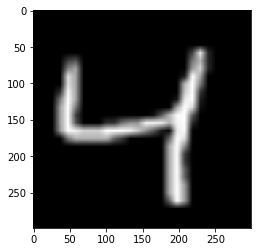

In [ ]:
mnist_dataset = MNIST(root=".", download=True)

# Get 200 MNIST examples
mnist_examples = mnist_dataset.data[:32].type(torch.FloatTensor)
mnist_examples /= 255

resizer = Resize(299)
mnist_examples = resizer(mnist_examples)

plt.imshow(mnist_examples[2].numpy(), interpolation='nearest', cmap='gray')

# Reshape the images to 3D to give them as inputs to the Inception network
mnist_examples = mnist_examples.unsqueeze(dim=3).repeat((1, 1, 1, 3))

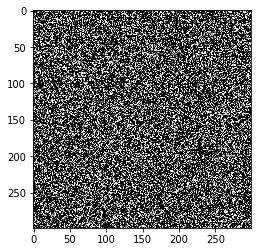

In [ ]:
# Create 200 noisy images as the same sizes with MNIST
noisy_examples = torch.randn(32, 299, 299, 1).clip(0, 1).repeat((1, 1, 1, 3))

plt.imshow(noisy_examples[2].numpy(), interpolation='nearest', cmap='gray')

In [ ]:
# Download the pretrained inception v3 model
inception_model = inception_v3(pretrained=True)
# Replace the classification layer with an identity layer to get the activations
inception_model.fc = nn.Identity()
# Evaluation mode
inception_model.eval()

with torch.no_grad():
  mnist_features = inception_model(mnist_examples.permute(0, 3, 1, 2))
  noisy_features = inception_model(noisy_examples.permute(0, 3, 1, 2))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
mnist_features.shape == noisy_features.shape

True

In [ ]:
from scipy.linalg import sqrtm

# Solution taken from: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(real_features, fake_features):
  """Calculates the Frechet Inception Distance of the given real and fake features
  to measure the similarity of two data distributions
  
  Args:
    real_features: Features taken from the real images (N x D)
    fake_features: Features taken from the fake images (N x D)
  Returns:
    A scalar number as the distance between two data distributions
  """
  # calculate mean and covariance statistics
  mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
  mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

In [ ]:
calculate_fid(mnist_features.numpy(), noisy_features.numpy())

396.46000186190406

In [ ]:
calculate_fid(mnist_features.numpy()[:16], mnist_features.numpy()[16:])

95.29507726881653